# Solving MNIST problem with CNN

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms # torchvision contains common datasets and preprosess funcs

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Prepare model

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
    
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

## Download dataset

In [4]:
transform = transforms.Compose([
                                transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
training_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
validation_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

## Prepare dataset

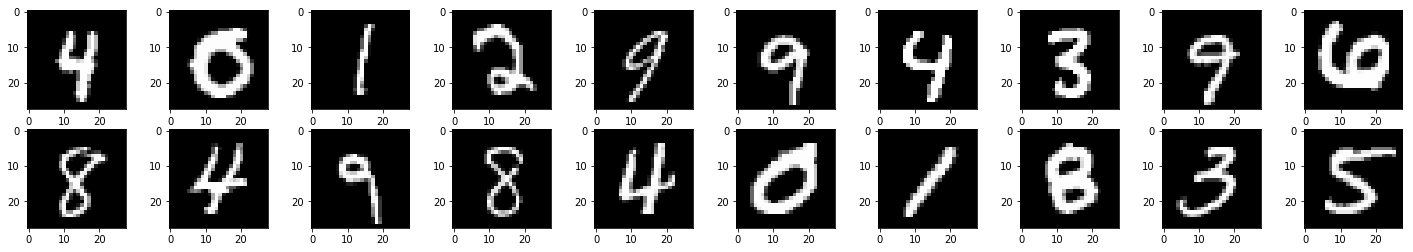

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    img = im_convert(images[idx])
    plt.imshow(img)
    ax.set_label([labels[idx].item()])

## Prepare model

In [6]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


## Train model

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print("Epoch:", (i+1))
        print("Training loss: {:.4f}, acc: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("Validation loss: {:.4f}, val acc: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

Epoch: 1
Training loss: 0.5985, acc: 83.5633
Validation loss: 0.1998, val acc: 93.9700
Epoch: 2
Training loss: 0.1574, acc: 95.2833
Validation loss: 0.1070, val acc: 96.9000
Epoch: 3
Training loss: 0.1024, acc: 96.9833
Validation loss: 0.0739, val acc: 97.7400
Epoch: 4
Training loss: 0.0797, acc: 97.6333
Validation loss: 0.0654, val acc: 98.0400
Epoch: 5
Training loss: 0.0658, acc: 98.0000
Validation loss: 0.0559, val acc: 98.2500
Epoch: 6
Training loss: 0.0564, acc: 98.3183
Validation loss: 0.0471, val acc: 98.4400
Epoch: 7
Training loss: 0.0494, acc: 98.4733
Validation loss: 0.0399, val acc: 98.7700
Epoch: 8
Training loss: 0.0429, acc: 98.7117
Validation loss: 0.0392, val acc: 98.7400
Epoch: 9
Training loss: 0.0401, acc: 98.8067
Validation loss: 0.0401, val acc: 98.6600
Epoch: 10
Training loss: 0.0361, acc: 98.8767
Validation loss: 0.0345, val acc: 98.9200
Epoch: 11
Training loss: 0.0334, acc: 98.9733
Validation loss: 0.0338, val acc: 98.9100
Epoch: 12
Training loss: 0.0300, acc: 99.

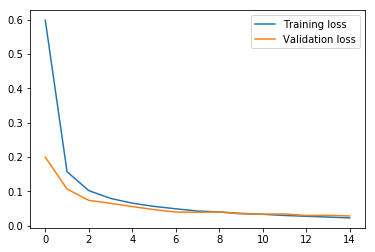

In [9]:
plt.plot(running_loss_history, label="Training loss")
plt.plot(val_running_loss_history, label="Validation loss")
plt.legend()

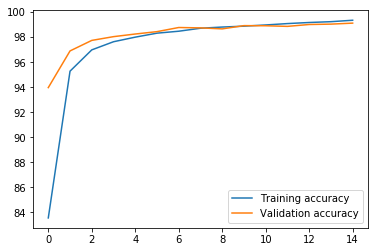

In [10]:
plt.plot(running_corrects_history, label="Training accuracy")
plt.plot(val_running_corrects_history, label="Validation accuracy")
plt.legend()

## Show model validation

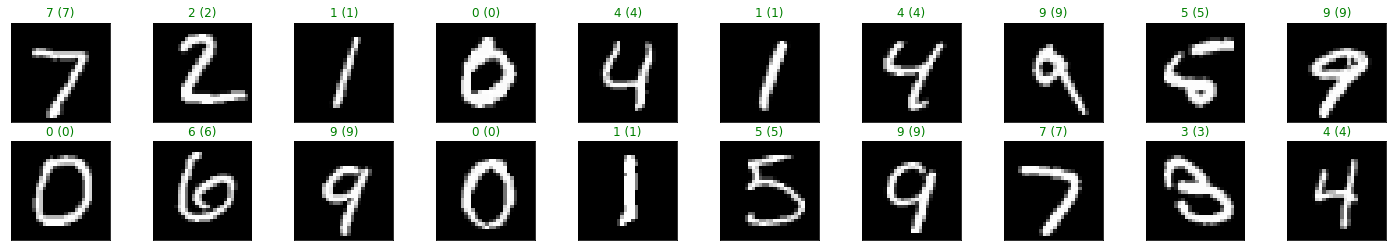

In [11]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

## Test on a random image

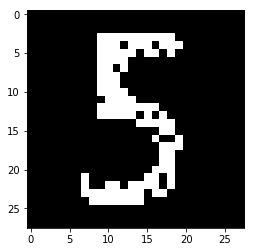

In [12]:
import requests
import PIL.ImageOps
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
resp = requests.get(url, stream=True)
img = Image.open(resp.raw)

img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [13]:
img = img.to(device)
img = img[0].unsqueeze(0).unsqueeze(0)
output = model(img)
_, pred = torch.max(output, 1)
print("Predicted number:", pred.item())

Predicted number: 5
